TODO:
- many qbits in circuit after target
- removing qArith for qVarArith after testing
- ensure we have the right answer at the end
- how is best to do multicontrol not (MCX). Should we do all in one MCX operation or separate it out? Which is less noisy?
- recycling the carry bit (adder paper). Could we use the same carry bit for all additions in the circuit? Uncompute carry after each one. Noisiness vs bit-saving.


In [1]:
from qiskit import *
from qiskit import QuantumRegister
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit import providers
from qiskit.providers.aer import AerSimulator
from qiskit.tools.monitor import job_monitor

import matplotlib as mpl
import random
import pylatexenc
import numpy as np
import pandas as pd
from pandas import *
import copy
import os



In [2]:
#IBMQ.save_account("83eab2c789e4b9b5030af0f6cdcf31f3efe4f59d505bff881e43504814b25b12526b1aa8c2b5826af475da8c49d3ca4f99189e59287d8040cb3750b728aa6b76")
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")

/Users/angelobenoit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  
/Users/angelobenoit/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  


# Quantum Circuit Class

In [4]:
##
##  A class to wrap the qiskit QuantumCircuit
##    It can allocate registers in sequence, which is very useful
##
class QC:
    def __init__(self, genBarriers=True):
        self.regNum = 0
        self.genBarriers = genBarriers
        self.qcx = QuantumCircuit()
        self.falseBit = self.addReg('false')
        self.trueBit  = self.addReg('true')
        self.qcx.x(self.trueBit)
        
    def getQuantumCircuit(self):
        return self.qcx

    def get_name(self, prefix=""):
        name = prefix+"_"+str(self.regNum)
        self.regNum+=1
        return name        
    
    def addReg(self, prefix="t"):
        name = self.get_name(prefix)
        result = QuantumRegister(1, name)
        self.qcx.add_register(result)
        return result

##
##  Measure the specified qubit onto a new classical bit
##     returns:  the classical register
##
    def mbit(self, qbit):
        result = ClassicalRegister(1, "m"+qbit.name)
        self.qcx.add_register(result)
        self.qcx.measure(qbit, result)
        return result

##
##  Put in barriers, or not, as dicitated by self.genBarriers
##
    def barrier(self):
        if self.genBarriers:
            self.qcx.barrier()
##
##  Emulate locally
##
    def em(self, shots=512):
        # em = Aer.get_backend("qasm_simulator")
        em = Aer.get_backend('aer_simulator_matrix_product_state')
        # job = execute(self.qcx, em, shots=shots)
        job = execute(self.qcx, em, shots=shots)
        hist = job.result().get_counts()
        return hist
    
##
## ToDo:  pick the method according to the number of qubits
## NB:   the usual simulator was ibmq_qasm_simulator by default
##    but we're using the one better suited to our purposes
##    Possiblities for method:
##        ibmq_qasm_simulator
##        simulator_mps
##
##
    def bem(self, shots=512, method='simulator_mps'):
        provider = IBMQ.get_provider(hub='ibm-q')
        real_device = provider.get_backend("simulator_mps")
        print('Status:')
        print('  Operational: ', real_device.status().operational)
        print('  Pending jobs:', real_device.status().pending_jobs)
        print('  Status message:', real_device.status().status_msg)
        job = execute(self.qcx, real_device, shots=shots)
        job_monitor(job, interval=2)
        res = job.result()
        return res.get_counts()
    
    def sv(self):
        svs = BasicAer.get_backend("statevector_simulator")
        job = execute(self.qcx, svs)
        ket = job.result().get_statevector()
        return ket
    
    
##
## Idea: split from here below into another decorator class
##
    
    def genOutput(self, reg, name):
        reg = reg if reg else self.addReg(name)
        return reg
    
    def qand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "and")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.barrier()
        return output


    def qor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "or")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.qcx.ccx(bit1, bit2, output)
        self.barrier()
        return output
    
    def qxor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "xor")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.barrier()
        return output
##
##  While we don't need this method for completeness,
##     it can perform a 3-way xor without generating a
##     temporary, intermediate result, thus saving qubits
##
    def qxor3(self, bit1, bit2, bit3, name="xor3", output=None):
        output = self.genOutput(output, name)
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.qcx.cx(bit3, output)
        self.barrier()
        return output

    def qnot(self, bit, output=None):
        output = self.genOutput(output, "not")
        self.barrier()
        self.qcx.x(bit)
        self.qcx.cx(bit, output)
        self.qcx.x(bit)
        self.barrier()
        return output

    def qnand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "nand")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.qcx.x(output)
        self.barrier()
        return output

###
### A more qulever carry computation, requiring no intermediate results
###   If exactly two bits are true, the output is flipped once, making it True
##    If all three are true, the output flips 3 times, making it True
##    If exactly one bit is true, no flipping occurs
##
    def quarry(self, bit1, bit2, bit3, output=None):
        output = self.genOutput(output, "quarry")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.qcx.ccx(bit2, bit3, output)
        self.qcx.ccx(bit1, bit3, output)
        self.barrier()
        return output
    
    
    def draw(self, output='mpl'):
        return self.qcx.draw(output=output)

# Quantum Arithmetic Class

In [5]:
##
##  Create integers and sums for the supplied quantum circuit
##    Throughout, a value is represented as a list of quantum registers,
##      least-significant-bit-first
##
class QVarArith:
    def __init__(self, qc):
        self.qc = qc
        self.ONE   = self.qint(1, "one")

    def numBits(self, val):
        if val == 0:
            return 1
        ans = int(np.log2(val))+1
        #print("For val " + str(val) + " " + str(ans) + " bits")
        return ans
##
##  Create the supplied value on the quantum circuit
##
    def qint(self, val, name=None, width=None):
        if not width:
            width = self.numBits(val)
        if not name:
            name = "qi("+str(val)+")"
        bitVal = []
        a = 1 #this would be the eventual separation point if we want to separate qint into defining width and values
        for i in range(width):
            t = self.qc.addReg(name)
            if val & a:
                self.qc.getQuantumCircuit().x(t)
            a = a << 1
            bitVal.append(t)
        return bitVal
    
#this is so our shadow registers for qvar can have defined length w/out defined value
    def qtemp(self,val,name=None):
        width = self.numBits(val)
        if not name:
            name = "qtempshad("+str(val)+")"
        bitVal = []
        for i in range(width):
            t = self.qc.addReg(name)
            bitVal.append(t)
        return bitVal
##
##  cin -- carry in
##  ba - one bit of input
##  bb -- other bit of input
##  returns the sum and carry bits
##  Note:  this is correct but chews up many temporary qubits
##
    def onebit(self, cin, ba, bb):
        ##
        ##  Using a 3-way :-) to save on qubits
        ##
        s = self.qc.qxor3(cin, ba, bb, name="add")
        ##
        ##  https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder
        ##  ba bb   +   cin (ba xor bb)
        # cout = self.qc.qor(self.qc.qand(ba,bb), self.qc.qand(cin,self.qc.qxor(ba,bb)))
        ##  Not using the above formuala, correct though it be
        ##    It generates 3 intermediate results, but the line below generates none
        ##
        cout = self.qc.quarry(cin, ba, bb)
        return s, cout
    
    def onebitshort(self, cin, ba, output=None):
        output = self.qc.genOutput(output, "quarry")
        s = self.qc.qxor(cin, ba)
        
        self.qc.getQuantumCircuit().ccx(cin, ba, output)
        return s, output
##
##  add the two inputs, returning the result
##
##  NB:  There is an opportunity to save one qubit here
##     The onebit call always generates both the sum s and the carry out, 
##        received as carry.  The carry is needed in the middle but not for
##        the very last onebit call
##     Making onebit aware of this would make the code ugly, I think [ RKC ]
##     Perhaps better would be to compute the sum and carry separately
##        and avoid the carry the last time. The onebit method is really just
##        those two calls, anyway, so this wouldn't be so hard.
##
    def add(self, val1, val2, width = 10):
        if len(val1) > len(val2):
            return self.add(val2, val1, width)
        ans   = []
        carry = self.qc.falseBit
        for i in range(len(val2)):
            if i<len(val1):
                s, carry = self.onebit(carry, val1[i], val2[i])
                ans.append(s)
            else:
                ##only need to add val2 and the carry at this point
                s, carry = self.onebitshort(carry, val2[i])
                ans.append(s)
        while len(ans) < width:
            ans.append(carry)
            carry = self.qc.addReg('pad')
        return ans
    
    def onescomp(self, val):
        self.qc.barrier()
        width = len(val)
        ans = []
        for i in range(width):
            ans.append(self.qc.qnot(val[i]))
        self.qc.barrier()
        return ans
            
    def neg(self, val): 
        return self.add(self.onescomp(val), self.ONE, len(val))
    
    def measure(self, val):
        width = len(val)
        result = []
        for i in range(width):
            b = self.qc.mbit(val[i])
            result.append(b)
        return result
    
    

Quantum Arithmetic Example 

In [6]:
##
## 32 bit addition problem
##
qc = QC()
qi = QVarArith(qc)
ans = qi.qint(0)
for i in range(1,10):
    n = qi.qint(i)
    ans = qi.add(ans,n)
m = qi.measure(ans)
#qc.draw()
#qc.em(shots=16)

# Subset Sum Class

In [32]:
class QSubsetSum:
    
    def __init__(self, values, target, qc=None):
        if not qc:
            self.qc = QC()
        else:
            self.qc = qc
        self.values = values
        self.target = target
        # print(self.target)
    #move tester outside class
    
    
    def run(self, sorted = True, partial = True, variable=True):
        if sorted:
            self.values.sort()
        widthOfSum = int(np.log2(sum(self.values)))+1 #placeholder: width = log2(sum) -- code this
        self.qi = QVarArith(self.qc)
        if variable:
            qintwidth = None
        else:
            qintwidth = widthOfSum
        
        self.x = []
        for i in range(len(self.values)): #creates x register
            r = self.qc.addReg(prefix = "x")
            self.x.append(r)
            ##
            ##  go ahead and call for the superposition of all
            ##   possible x values
            ##
            self.qc.getQuantumCircuit().h(r)
        print(self.x)
        ##
        ##  sorted and unsorted versions
        ##
        ##  Create the running sum of integers in my (unsorted) set
        ##  ans maintains the running sum, and is returned at thend
        ##  By "sum" we mean that each integer in the set is either added
        ##    into the sum, or not, depending on the x control register
        ##  
        ##  ans starts out as a new register, all 0
        ##
        ans = self.qi.qint(0, name = "sum")
        
        if partial:
            totsum = 0
        else:
            totsum = int(sum(self.values))
        for i, s in enumerate(self.values): #stores integers as quantum registers
            r = self.qi.qint(s)
            ctrl = self.x[i]
            if partial:
                totsum += self.values[i]
            # print(partialSum)
            ##make qtemp function that allocates result reg as big as s
            shadow = self.qi.qtemp(s, name = "shd")
            # print(len(shadow))
            for a in range(len(shadow)):
                self.qc.getQuantumCircuit().ccx(ctrl, r[a], shadow[a]) #
            ans = self.qi.add(ans, shadow, self.qi.numBits(totsum))
            # ans = self.qi.add(ans, shadow, self.bigSum)
            # print("ans", ans)
        targ = self.qi.qint(self.target, name = "target", width=len(ans))
        targ = self.qi.neg(targ)
        subtraction = self.qi.add(ans, targ, self.qi.numBits(totsum))
        self.qi.measure(subtraction)
        # self.qi.measure(ans)
        print(self.qc.regNum)
        return subtraction

    
    ##
    ## variable: use variable length addition, if false used fixed
    ## this is identical to run execept it returns the # of registers instead of the subtraction result.
    def testRun(self, sorted = True, partial = True, variable=True):
        if sorted:
            self.values.sort()
        widthOfSum = int(np.log2(sum(self.values)))+1 #placeholder: width = log2(sum) -- code this

        self.qi = QVarArith(self.qc)
        if variable:
            qintwidth = None
        else:
            qintwidth = widthOfSum
        
        self.x = []
        for i in range(len(self.values)): #creates x register
            r = self.qc.addReg(prefix = "x")
            self.x.append(r)
            self.qc.getQuantumCircuit().h(r)
        ans = self.qi.qint(0, name = "sum")
        
        if partial:
            totsum = 0
        else:
            totsum = int(sum(self.values))

        for i, s in enumerate(self.values): #stores integers as quantum registers
            r = self.qi.qint(s, width=qintwidth)
            ctrl = self.x[i]
            if partial:
                totsum += self.values[i]
            shadow = self.qi.qtemp(s, name = "shd")
            for a in range(len(shadow)):
                self.qc.getQuantumCircuit().ccx(ctrl, r[a], shadow[a]) #
            ans = self.qi.add(ans, shadow, self.qi.numBits(totsum))
            
        targ = self.qi.qint(self.target, name = "target", width=len(ans))
        targ = self.qi.neg(targ)
        subtraction = self.qi.add(ans, targ, self.qi.numBits(totsum))
        self.qi.measure(subtraction)

        gateSum=0
        gates = self.qc.getQuantumCircuit().count_ops()
        for key, value in gates.items():
            if key not in ['barrier', 'measure']:
                gateSum += value

        # return self.qc.regNum
        print(gateSum)
        return gateSum
        


# Qubit Usage Testing

In [8]:
def tester(numVals, maxVal=None):
        
        if not maxVal:
            maxVal = 64
        randomlist = []
        for i in range(int(numVals)):
            n = random.randint(1,maxVal)
            randomlist.append(n)
        target = random.randint(1,sum(randomlist))
        
        print("number list: "+str(randomlist)+ "|  target: "+str(target))
        qsub1 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans = qsub1.testRun(True, True, True) #varArith with sorted values and partial sum
        qsub2 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans2 = qsub2.testRun(False, True, True) #varArith with unsorted values and partial sum
        qsub3 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans3 = qsub3.testRun(False, False, True) #varArith with unsorted values and total sum
        qsub4 = QSubsetSum(copy.deepcopy(randomlist), target)
        ans4 = qsub4.testRun(True, True, False) #fixedArith with sorted values and partial sum
        return ans, ans2, ans3, ans4

In [33]:
d = {'sorted,partial,varArith':[], 'unsorted,partial,varArith':[], 'unsorted,bigSum,varArith':[], 'fixedArith':[]}
df = pd.DataFrame(data=d)

#loop over all numvals of tester

#number of values to check: [5,10,15]?
#maxVal values to check: [64, 128, 256]?
#number of runs for each data point: 50? 100? 250?

for i in range(100):
    test = tester(30, 256)
    
    df.loc[len(df.index)] = [test[0], test[1],test[2], test[3]]

#display(df)
df.loc[len(df.index)] = df.mean()
os.makedirs('tests', exist_ok=True)  
df.to_csv('tests/30vals256max.csv')  


number list: [204, 253, 220, 145, 70, 227, 83, 15, 133, 215, 73, 218, 138, 129, 106, 204, 142, 71, 256, 93, 117, 195, 124, 85, 123, 98, 38, 248, 153, 148]|  target: 3729
2114
2201
2348


KeyboardInterrupt: 

TEST LOOP

In [28]:
d = {'sorted,partial,varArith':[], 'unsorted,partial,varArith':[], 'unsorted,bigSum,varArith':[], 'fixedArith':[]}

for num in range(5, 36, 5):
    df = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 64)
        df.loc[len(df.index)] = [test[0], test[1],test[2], test[3]]

    #display(df)
    df.loc[len(df.index)] = df.mean()
    os.makedirs('tests', exist_ok=True)  
    df.to_csv('tests/'+str(num)+'vals64max.csv')


    df = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 128)
        df.loc[len(df.index)] = [test[0], test[1],test[2], test[3]]

    #display(df)
    df.loc[len(df.index)] = df.mean()
    os.makedirs('tests', exist_ok=True)  
    df.to_csv('tests/'+str(num)+'vals128max.csv')


    df = pd.DataFrame(data=d)
    for i in range(100):
        test = tester(num, 256)
        df.loc[len(df.index)] = [test[0], test[1],test[2], test[3]]

    #display(df)
    df.loc[len(df.index)] = df.mean()
    os.makedirs('tests', exist_ok=True)  
    df.to_csv('tests/'+str(num)+'vals256max.csv')



number list: [22, 98, 63, 63, 97, 57, 93, 39, 68, 120, 61, 17, 13, 5, 50, 122, 77, 35, 71, 51, 84, 71, 15, 108, 99, 4, 128, 85, 55, 10, 15, 34, 101, 48, 13, 59, 61, 80, 16, 109, 108, 60, 75, 80, 113, 18, 87, 117, 111, 99, 56, 54, 84, 22, 107, 41, 88, 38, 18, 127, 74, 109, 34, 22, 96]|  target: 3718
number list: [68, 70, 102, 97, 8, 1, 50, 68, 123, 84, 2, 104, 110, 124, 47, 80, 68, 85, 37, 14, 13, 105, 1, 48, 57, 98, 22, 30, 118, 44, 117, 48, 112, 121, 66, 56, 52, 86, 80, 90, 80, 46, 36, 105, 40, 67, 99, 10, 128, 52, 77, 97, 19, 27, 95, 103, 97, 116, 127, 94, 52, 16, 52, 111, 33]|  target: 2605
number list: [15, 73, 15, 9, 57, 81, 35, 107, 15, 16, 19, 71, 99, 58, 25, 100, 83, 24, 51, 117, 66, 85, 118, 4, 96, 14, 102, 68, 52, 76, 32, 13, 125, 46, 105, 109, 112, 59, 63, 44, 46, 56, 85, 1, 94, 117, 5, 103, 39, 10, 84, 95, 42, 95, 9, 92, 100, 17, 37, 113, 89, 40, 120, 77, 85]|  target: 642
number list: [17, 23, 58, 5, 110, 24, 49, 88, 25, 58, 78, 81, 110, 116, 81, 107, 67, 119, 105, 32, 16,

KeyboardInterrupt: 

PLOTTING QUBIT COUNT RESULTS

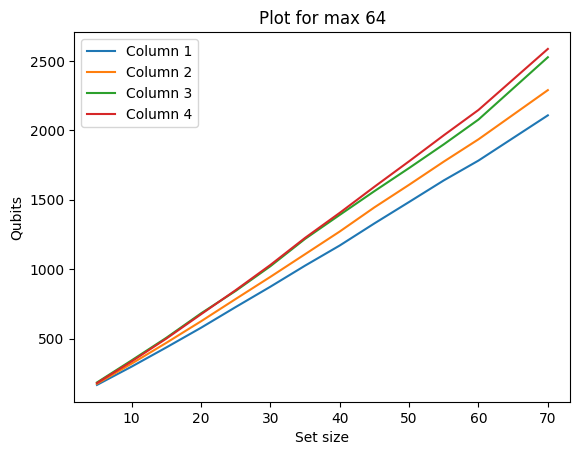

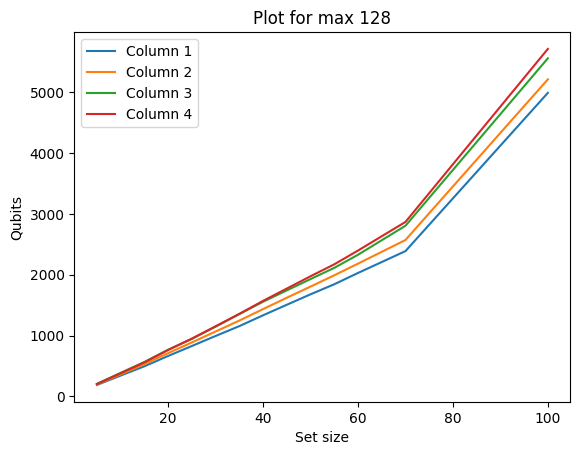

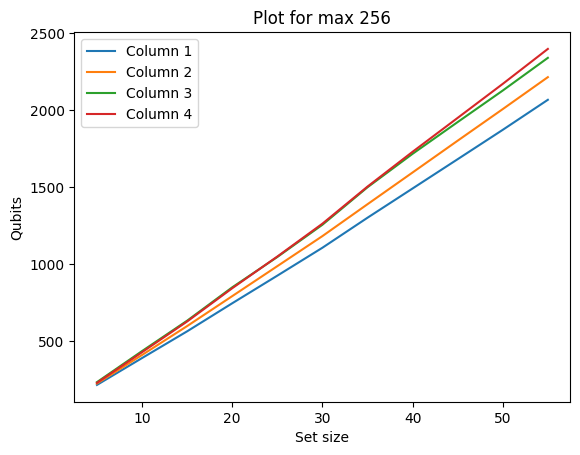

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv

# Function to list all relevant CSV files in the directory
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('max.csv')]

# Function to parse filename and extract the values and max number
def parse_filename(filename):
    parts = filename.split('vals')[0], filename.split('max.csv')[0].split('vals')[-1]
    return int(parts[0]), int(parts[1])  # Return vals, max as integers

# Function to group files by their max value
def group_files_by_max(files):
    groups = {}
    for file in files:
        _, max_val = parse_filename(file)
        if max_val not in groups:
            groups[max_val] = [file]
        else:
            groups[max_val].append(file)
    return groups

# Function to extract the last line of each file and create a numpy array
# def create_numpy_array_for_group(files, directory):
#     data = []
#     for file in files:
#         vals, _ = parse_filename(file)
#         with open(os.path.join(directory, file), 'r') as csvfile:
#             for last_line in csvfile:
#                 pass
#             data.append([vals] + list(map(float, last_line.strip().split(','))))
#     data = np.array(data)
#     data = data[data[:, 0].argsort()]  # Sort by vals
#     return data
# Function to extract the last line of each file, excluding the first column, and create a numpy array
def create_numpy_array_for_group(files, directory):
    data = []
    for file in files:
        vals, _ = parse_filename(file)
        with open(os.path.join(directory, file), 'r') as csvfile:
            for last_line in csvfile:
                pass
            # Exclude the first column ([1:]) from each CSV's last line
            data.append([vals] + list(map(float, last_line.strip().split(',')[1:])))
    data = np.array(data)
    data = data[data[:, 0].argsort()]  # Sort by vals
    return data


# def plot_data(groups, directory):
#     for max_val, files in groups.items():
#         plt.figure()  # Create a new figure for each max group
#         data = create_numpy_array_for_group(files, directory)
#         for i in range(1, data.shape[1]):  # Skip the first column as it's vals
#             plt.plot(data[:, 0], data[:, i], label=f'Column {i}')
#         plt.xlabel('Set size')
#         plt.ylabel('Qubits')
#         plt.title(f'Plot for max {max_val}')
#         plt.legend()
#         plt.show()
# Function to plot the data from numpy arrays, with separate plots for each max group and labeled columns
def plot_data(groups, directory):
    # Define column labels according to the specified mapping
    column_labels = [
        "sorted, partial sum, variable arith",
        "unsorted, partial sum, variable arith",
        "unsorted, total sum, variable arith",
        "sorted, partial sum, fixed arith"
    ]
    
    for max_val, files in groups.items():
        plt.figure()  # Create a new figure for each max group
        data = create_numpy_array_for_group(files, directory)
        for i in range(1, data.shape[1]):  # Skip the first column as it's vals
            # Use the column index (i-1) to get the appropriate label from column_labels list
            label = column_labels[i-1] if i-1 < len(column_labels) else f'Column {i}'
            plt.plot(data[:, 0], data[:, i], label=label)
        plt.xlabel('Set Size')
        plt.ylabel('Number of Qubits')
        plt.title(f'Qubit Counts for Maximum Value of {max_val}')
        plt.legend()
        plt.show()



# Main function to orchestrate the operations
def main(directory):
    files = list_csv_files(directory)
    grouped_files = group_files_by_max(files)
    plot_data(grouped_files, directory)

# Note: Uncomment the line below and specify the directory path to run the script
main('tests')

# This code is structured to be easily understandable and maintainable, following the steps outlined in the approach.


# Subtraction Result Testing

In [ ]:
s = [2,9,26,7,12]
# s = [2,9] 
### pre target
# [2,7] -> partialSum - 26 qbits, bigSum - 29 qbits
# [2,9,7] -> sorted partialSum - 44 qbits, unsorted partialSum - 45qbits, bigSum - 51 qbit
# [2,9,26,7,12] -> sorted partialSum - 86 qbits, unsorted partialSum - 92qbits, bigSum - 101 qbit

###post target
# [2,9,26,7,12] -> sorted partialSum - 122 qbits, unsorted partialSum - 92qbits, bigSum - 101 qbit

target = 0
qsub = QSubsetSum(s, target)

# qc, test = tester(2)
# print(test)
qsub.run()
# too big for now
# qc.draw('mpl')

def twosToBinary(binary_str):
    binary_str = binary_str.replace(" ", "")
    is_negative = binary_str[0] == '1'
    if is_negative:
            inverted_bits = ''.join('1' if bit == '0' else '0' for bit in binary_str[1:])
            binary_str = bin(int(inverted_bits, 2) + 1)[2:]
    decimal_value = int(binary_str, 2)
    if is_negative:
        decimal_value = -decimal_value
    return decimal_value

# print(res.keys())
res = qc.em()
newdict = {}
newdict['Value'] = 'Counts'
for key in res.keys():
    newkey = twosToBinary(key)
    newdict[newkey]=[res[key]]
df = pd.DataFrame.from_dict(newdict)
df = df.transpose()
df = df.rename(columns={0: ''})
print(df)
# print(res)
